<a href="https://colab.research.google.com/github/joguipi/FT105A/blob/main/TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação de todas as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import requests
from io import BytesIO

## Leitura e Organização dos Dados

**Leitura dos dados sobre o volume do sistema cantareira.**  
Os dados foram obtidos do portal dos mananciais da sabesp  
https://mananciais.sabesp.com.br/Situacao



In [2]:
dados = []
df = pd.DataFrame()
for ano in range(2010,2024):
  url = "https://github.com/joguipi/FT105A/raw/main/sistemas_produtores_"+str(ano)+".xlsx"
  response = requests.get(url)
  response.raise_for_status()  # Verifica se houve algum erro na requisição

  df = pd.read_excel(BytesIO(response.content), engine='openpyxl', header = 1)
  dados.append(df)
dados[0]

,Data,Volume (hm³),Volume (%),Chuva (mm),Vazão natural (m³/s),Vazão a jusante (m³/s)
0,31/12/2010,736.45197,74.98961,1.150,24.049,4.76
1,30/12/2010,737.45934,75.09219,0.050,41.798,4.50
2,29/12/2010,736.92883,75.03817,0.100,58.374,4.91
3,28/12/2010,735.06450,74.84833,2.500,86.336,5.50
4,27/12/2010,730.83849,74.41802,57.200,155.359,5.50
...,...,...,...,...,...,...
360,05/01/2010,949.31996,96.44907,6.150,90.460,85.97
361,04/01/2010,951.64795,96.68559,0.000,93.507,88.10
362,03/01/2010,953.58761,96.88266,3.875,128.161,87.14
363,02/01/2010,952.34991,96.75691,54.850,164.671,84.14


In [3]:
# Precisamos ajustar a coluna Data para o time DateTime
dados[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Data                    365 non-null    object 
 1   Volume (hm³)            365 non-null    float64
 2   Volume (%)              365 non-null    float64
 3   Chuva (mm)              365 non-null    float64
 4   Vazão natural (m³/s)    365 non-null    float64
 5   Vazão a jusante (m³/s)  365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB


In [4]:
for i in range(0,len(dados)):
  #dados[i]['Data'] = dados[i]['Data'].dt.strftime('%d/%m/%Y')
  dados[i]['Data'] = pd.to_datetime(dados[i]['Data'], format='%d/%m/%Y')
  dados[i] = dados[i].sort_values(by='Data').reset_index(drop=True)
dados[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Data                    365 non-null    datetime64[ns]
 1   Volume (hm³)            365 non-null    float64       
 2   Volume (%)              365 non-null    float64       
 3   Chuva (mm)              365 non-null    float64       
 4   Vazão natural (m³/s)    365 non-null    float64       
 5   Vazão a jusante (m³/s)  365 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 17.2 KB


In [5]:
dados[0]

,Data,Volume (hm³),Volume (%),Chuva (mm),Vazão natural (m³/s),Vazão a jusante (m³/s)
0,2010-01-01,947.35506,96.24944,0.650,85.995,84.15
1,2010-01-02,952.34991,96.75691,54.850,164.671,84.14
2,2010-01-03,953.58761,96.88266,3.875,128.161,87.14
3,2010-01-04,951.64795,96.68559,0.000,93.507,88.10
4,2010-01-05,949.31996,96.44907,6.150,90.460,85.97
...,...,...,...,...,...,...
360,2010-12-27,730.83849,74.41802,57.200,155.359,5.50
361,2010-12-28,735.06450,74.84833,2.500,86.336,5.50
362,2010-12-29,736.92883,75.03817,0.100,58.374,4.91
363,2010-12-30,737.45934,75.09219,0.050,41.798,4.50


In [6]:
#Juntar todos os anos num unico dataframe (tabela)
dfCantareira = pd.concat(dados, ignore_index=True)
dfCantareira

,Data,Volume (hm³),Volume (%),Chuva (mm),Vazão natural (m³/s),Vazão a jusante (m³/s),Vazão retirada (m³/s)<br/>ETA Guaraú
0,2010-01-01,947.35506,96.24944,0.650,85.995,84.15,NaN
1,2010-01-02,952.34991,96.75691,54.850,164.671,84.14,NaN
2,2010-01-03,953.58761,96.88266,3.875,128.161,87.14,NaN
3,2010-01-04,951.64795,96.68559,0.000,93.507,88.10,NaN
4,2010-01-05,949.31996,96.44907,6.150,90.460,85.97,NaN
...,...,...,...,...,...,...,...
5108,2023-12-27,708.90399,72.18452,6.400,24.091,6.85,28.24206
5109,2023-12-28,707.77838,72.06991,0.000,20.914,6.85,28.56808
5110,2023-12-29,706.88515,71.97895,0.000,25.675,8.02,28.55915
5111,2023-12-30,704.94710,71.78161,0.000,13.881,8.85,25.65419


In [7]:
valores_zero = dfCantareira.isin([0]).any()
print("Colunas com valores zero:")
print(valores_zero[valores_zero].index.tolist())

Colunas com valores zero:
['Chuva (mm)']


**Leitura dos dados sobre a temperatura.**  
Os dados foram obtidos de CIIAGRO http://www.ciiagro.org.br/cpmensal

In [8]:
#cidades = ['CAMPINAS', 'ATIBAIA', 'BRAGANÇA PAULISTA', 'INDAIATUBA', 'ITATIBA', 'JAGUARIUNA', 'LIMEIRA', 'NAZARÉ PAULISTA', 'PIRACICABA', 'VALINHOS', 'COSMÓPOLIS', 'RIO CLARO', 'AMERICANA', 'MORUNGABA']
cidades = ['Campinas','Atibaia1', 'Paulinia', 'Piracicaba', 'Jaguariuna', 'NazaréPaulista', 'Itatiba', 'Valinhos', 'BragancaPaulista', 'Morungaba','Cosmópolis', 'Limeira', 'Americana', 'RioClaro', 'Indaiatuba']

In [9]:
dados = {}
df = pd.DataFrame()
url = "https://github.com/joguipi/FT105A/raw/main/Umidade_Temperatura.xlsx"
response = requests.get(url)
response.raise_for_status()  # Verifica se houve algum erro na requisição
for cidade in cidades:
  df = pd.read_excel(BytesIO(response.content), engine='openpyxl', header = 3, sheet_name=cidade)
  df.columns = ["Data", 'Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média', 'Precipitação (mm)']
  df = df.drop(df.index[-1]) # Remover a última linha.
  df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')
  dados[cidade] = df
dados['Atibaia'] = dados.pop('Atibaia1')
dados['Itatiba']

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,18.32,31.89,33.69,91.21,116.37
1,2014-02-01,18.87,32.91,30.14,86.68,66.05
2,2014-03-01,17.89,29.41,42.77,91.91,137.40
3,2014-04-01,15.47,27.44,44.98,92.97,73.91
4,2014-05-01,12.05,25.22,41.62,92.64,23.63
...,...,...,...,...,...,...
116,2023-09-01,15.98,29.09,37.79,88.40,103.13
117,2023-10-01,17.09,27.34,56.97,95.96,258.06
118,2023-11-01,17.97,29.25,46.10,91.87,174.25
119,2023-12-01,18.09,30.25,42.55,92.55,81.54


In [10]:
#Verificando que todos tem a mesma quantidade de linhas.
for key in dados.keys():
  print(str(key)+ " " + str(len(dados[key])))

Campinas 121
Paulinia 121
Piracicaba 121
Jaguariuna 121
NazaréPaulista 121
Itatiba 121
Valinhos 121
BragancaPaulista 121
Morungaba 121
Cosmópolis 121
Limeira 121
Americana 121
RioClaro 121
Indaiatuba 121
Atibaia 121


In [11]:
#Busca por cidades que possuem valores zerados
colunas_verificar = ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']

for cidade in dados.keys():
  # Verificando se há algum valor igual a zero nas colunas especificadas
  valores_zero = dados[cidade][colunas_verificar].isin([0]).any()

  # Exibindo as colunas que têm valores zero
  print(cidade + "- Colunas com valores zero:", end=' ')
  print(valores_zero[valores_zero].index.tolist())

Campinas- Colunas com valores zero: []
Paulinia- Colunas com valores zero: ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']
Piracicaba- Colunas com valores zero: []
Jaguariuna- Colunas com valores zero: []
NazaréPaulista- Colunas com valores zero: ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']
Itatiba- Colunas com valores zero: ['Umidade Mínima Média', 'Umidade Máxima Média']
Valinhos- Colunas com valores zero: ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']
BragancaPaulista- Colunas com valores zero: ['Umidade Mínima Média', 'Umidade Máxima Média']
Morungaba- Colunas com valores zero: ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']
Cosmópolis- Colunas com valores zero: ['Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']
Limeira- Colunas com valores zero: ['Umidade Mín

In [12]:
#PAULÍNIA
dados['Paulinia'][(dados['Paulinia'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 e 2015.

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [13]:
#Valinhos
dados['Valinhos'][(dados['Valinhos'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 e 2015.

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [14]:
#Morungaba
dados['Morungaba'][(dados['Morungaba'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 e 2015

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [15]:
#Cosmópolis
dados['Cosmópolis'][(dados['Cosmópolis'][colunas_verificar] == 0).any(axis=1)]
# A cidade de cosmópolis irá participar das médias nos anos de 2016 a 2020. Os outros anos estão incompletos.

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [16]:
#Americana
dados['Americana'][(dados['Americana'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 e 2015

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [17]:
#RioClaro
dados['RioClaro'][(dados['RioClaro'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 a 2017

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,0.0,0.0,0.0,0.0,0.0
1,2014-02-01,0.0,0.0,0.0,0.0,0.0
2,2014-03-01,0.0,0.0,0.0,0.0,0.0
3,2014-04-01,0.0,0.0,0.0,0.0,0.0
4,2014-05-01,0.0,0.0,0.0,0.0,0.0
5,2014-06-01,0.0,0.0,0.0,0.0,0.0
6,2014-07-01,0.0,0.0,0.0,0.0,0.0
7,2014-08-01,0.0,0.0,0.0,0.0,0.0
8,2014-09-01,0.0,0.0,0.0,0.0,0.0
9,2014-10-01,0.0,0.0,0.0,0.0,0.0


In [18]:
#Limeira
dados['Limeira'][(dados['Limeira'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2014 e 2016.
# Estimar os valores faltantes para os três registros faltantes de 2020.

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,18.54,31.65,0.0,0.0,74.8
1,2014-02-01,18.94,32.65,0.0,0.0,40.6
2,2014-03-01,17.84,30.62,0.0,0.0,117.4
3,2014-04-01,15.11,28.33,0.0,0.0,52.6
4,2014-05-01,12.21,27.01,0.0,0.0,4.6
5,2014-06-01,11.50,26.16,0.0,0.0,5.6
6,2014-07-01,12.47,28.49,0.0,0.0,13.0
7,2014-08-01,12.53,29.83,0.0,0.0,6.6
8,2014-09-01,18.79,33.85,0.0,0.0,71.0
9,2014-10-01,16.15,31.97,0.0,0.0,10.3


Vamos estimar os valores para os registros de ID 75, 76 e 77

In [19]:
def imputacaoVizinhoMaisProximo(dados, cidade, registros, coluna, qtdeVizinhos, filtro):
  dfCidade = dados[cidade].drop(columns=[coluna])
  if(filtro != ""):
    dfCidade = dfCidade.query(filtro)
  dfCidade = dfCidade.iloc[:,1:] # Remove a coluna Data
  distancias = pdist(dfCidade.values, 'euclidean')
  dist_matrix = squareform(distancias)
  dm = pd.DataFrame(dist_matrix, index=dfCidade.index, columns=dfCidade.index)
  qtdVizinhos = 3 #quantidade de vizinhos mais próximos
  for registro in registros:
    somatorio = 0
    #print(registro)
    for i in range(1,qtdVizinhos+1):
        idxVizinho = dm[registro].sort_values().index[i]
        #print("Vizinho mais próximo = " + str(idxVizinho) + " distancia = " + str(dm[registro].sort_values()[idxVizinho]))
        valor = dados[cidade].iloc[idxVizinho][coluna]
        #print(valor)
        somatorio = somatorio+valor
    somatorio = somatorio/qtdVizinhos
    print(round(somatorio,2))
    dados[cidade].at[registro, coluna] = round(somatorio,2)

In [20]:
imputacaoVizinhoMaisProximo(dados, 'Limeira', [75,76,77], 'Umidade Mínima Média', 3, "Data >= datetime.date(2017,1,1) and Data < datetime.date(2024,1,1)")
imputacaoVizinhoMaisProximo(dados, 'Limeira', [75,76,77], 'Umidade Máxima Média', 3, "Data >= datetime.date(2017,1,1) and Data < datetime.date(2024,1,1)")

10.1
12.45
20.18
62.52
83.39
92.88


In [21]:
#BragancaPaulista
dados['BragancaPaulista'][(dados['BragancaPaulista'][colunas_verificar] == 0).any(axis=1)]
# Estimar o valor de umidade

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
34,2016-11-01,15.76,27.2,0.0,0.0,126.9


In [22]:
imputacaoVizinhoMaisProximo(dados, 'BragancaPaulista', [34], 'Umidade Mínima Média', 3, "")
imputacaoVizinhoMaisProximo(dados, 'BragancaPaulista', [34], 'Umidade Máxima Média', 3, "")

44.29
96.67


In [23]:
#Itatiba
dados['Itatiba'][(dados['Itatiba'][colunas_verificar] == 0).any(axis=1)]
# Como são um ano e meio sem informação, deixaremos de fora essa cidade no cálculo da média para os anos de 2015 e 2016

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
23,2015-12-01,17.69,29.12,0.0,0.0,116.6
24,2016-01-01,18.02,28.09,0.0,0.0,277.2
25,2016-02-01,19.12,30.41,0.0,0.0,201.3
26,2016-03-01,18.61,29.65,0.0,0.0,277.2
27,2016-04-01,17.98,31.62,0.0,0.0,5.1
31,2016-08-01,12.89,25.98,0.0,0.0,56.2
32,2016-09-01,14.31,26.98,0.0,0.0,54.4
33,2016-10-01,16.52,28.63,0.0,0.0,97.6
34,2016-11-01,17.13,28.94,0.0,0.0,168.0
35,2016-12-01,18.69,30.70,0.0,0.0,76.0


In [24]:
imputacaoVizinhoMaisProximo(dados, 'Itatiba', [23], 'Umidade Mínima Média', 3, "Data <= datetime.date(2015,12,1) or Data >= datetime.date(2017,1,1)")
imputacaoVizinhoMaisProximo(dados, 'Itatiba', [23], 'Umidade Máxima Média', 3, "Data <= datetime.date(2015,12,1) or Data >= datetime.date(2017,1,1)")

36.65
90.62


In [25]:
#Nazaré
dados['NazaréPaulista'][(dados['NazaréPaulista'][colunas_verificar] == 0).any(axis=1)]
#Serão estimados os valores faltantes

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
25,2016-02-01,18.54,30.19,0.0,0.0,253.4
26,2016-03-01,17.67,28.43,0.0,0.0,206.6
27,2016-04-01,17.06,29.18,0.0,0.0,8.0
91,2021-08-01,0.00,0.00,0.0,0.0,0.0


In [26]:
imputacaoVizinhoMaisProximo(dados, 'NazaréPaulista', [25,26,27], 'Umidade Mínima Média', 3, "")
imputacaoVizinhoMaisProximo(dados, 'NazaréPaulista', [25,26,27], 'Umidade Máxima Média', 3, "")

39.31
42.78
30.59
100.0
99.17
99.91


In [27]:
#Média valores anteriores e posteriores
for col in dados['NazaréPaulista'].columns[1:]:
  dados['NazaréPaulista'].at[91, col] = (dados['NazaréPaulista'].at[90, col] + dados['NazaréPaulista'].at[92, col]) / 2
dados['NazaréPaulista'].iloc[[90,91,92]]

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
90,2021-07-01,8.670,21.490,40.690,100.0,0.000
91,2021-08-01,11.675,25.535,37.965,100.0,14.735
92,2021-09-01,14.680,29.580,35.240,100.0,29.470


In [28]:
#Busca por cidades que possuem valores zerados
#for cidade in dados.keys():
#  fig, ax = plt.subplots(figsize=(10,5))
#  bplot = ax.boxplot((dados[cidade].drop('Data', axis='columns')), patch_artist=True, sym='x')
#  ax.set_title(cidade, fontsize=15)
#  ax.grid(True, axis='y')
#  ax.set_xticklabels(labels=dados[cidade].columns[1:], fontsize=8)
#  ax

Unificar através de uma média todas as informações

In [29]:
dados.keys()

dict_keys(['Campinas', 'Paulinia', 'Piracicaba', 'Jaguariuna', 'NazaréPaulista', 'Itatiba', 'Valinhos', 'BragancaPaulista', 'Morungaba', 'Cosmópolis', 'Limeira', 'Americana', 'RioClaro', 'Indaiatuba', 'Atibaia'])

In [30]:
for key in dados.keys():
  print(str(key)+ " " + str(len(dados[key])))

Campinas 121
Paulinia 121
Piracicaba 121
Jaguariuna 121
NazaréPaulista 121
Itatiba 121
Valinhos 121
BragancaPaulista 121
Morungaba 121
Cosmópolis 121
Limeira 121
Americana 121
RioClaro 121
Indaiatuba 121
Atibaia 121


In [31]:
dfTempUmid = pd.DataFrame(columns=dados['Campinas'].columns)

In [32]:
soma = 0
qtde = 0
linha = []
for index in range(0,len(dados['Campinas'])):
  data = dados['Campinas'].iloc[index]['Data']
  linha.append(data)
  for col in dados['Campinas'].columns[1:]:
    for cidade in dados.keys():
      if((cidade == 'Paulinia' or cidade == 'Valinhos' or cidade == 'Morungaba' or cidade == 'Americana') and (data.year == 2014 or data.year == 2015)):
        continue
      if(cidade == 'Itatiba' and (col == 'Umidade Mínima Média' or col == 'Umidade Máxima Média')) and (data.year == 2016):
        continue
      if(cidade == 'Limeira' and (col == 'Umidade Mínima Média' or col == 'Umidade Máxima Média')) and (data.year >= 2014 and data.year <= 2016):
        continue
      if(cidade == 'Cosmópolis' and (data.year < 2016 or data.year > 2020)):
        continue
      if(cidade == 'RioClaro' and data.year < 2017):
        continue
      soma = soma + dados[cidade].iloc[index][col]
      qtde = qtde + 1

    soma = soma / qtde
    linha.append(round(soma,2))
    soma = 0
    qtde = 0
  dfTempUmid.loc[index] = linha
  linha=[]
dfTempUmid

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,19.13,32.56,34.12,92.47,96.78
1,2014-02-01,19.64,33.19,30.71,87.19,50.54
2,2014-03-01,18.50,30.04,44.31,93.87,126.59
3,2014-04-01,16.07,27.98,46.72,94.74,78.29
4,2014-05-01,12.76,25.80,43.61,93.62,28.34
...,...,...,...,...,...,...
116,2023-09-01,16.54,31.94,38.44,94.00,74.46
117,2023-10-01,18.44,30.44,55.63,97.17,256.25
118,2023-11-01,18.93,32.24,44.98,95.14,197.55
119,2023-12-01,19.33,33.19,42.62,95.13,86.69


Necessário juntar as bases de dados

In [33]:
dfCantareira

,Data,Volume (hm³),Volume (%),Chuva (mm),Vazão natural (m³/s),Vazão a jusante (m³/s),Vazão retirada (m³/s)<br/>ETA Guaraú
0,2010-01-01,947.35506,96.24944,0.650,85.995,84.15,NaN
1,2010-01-02,952.34991,96.75691,54.850,164.671,84.14,NaN
2,2010-01-03,953.58761,96.88266,3.875,128.161,87.14,NaN
3,2010-01-04,951.64795,96.68559,0.000,93.507,88.10,NaN
4,2010-01-05,949.31996,96.44907,6.150,90.460,85.97,NaN
...,...,...,...,...,...,...,...
5108,2023-12-27,708.90399,72.18452,6.400,24.091,6.85,28.24206
5109,2023-12-28,707.77838,72.06991,0.000,20.914,6.85,28.56808
5110,2023-12-29,706.88515,71.97895,0.000,25.675,8.02,28.55915
5111,2023-12-30,704.94710,71.78161,0.000,13.881,8.85,25.65419


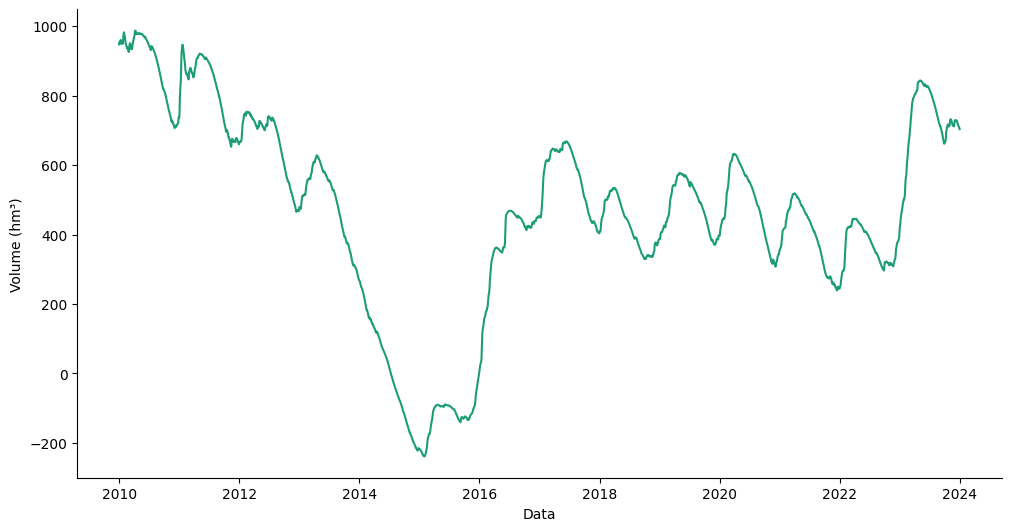

In [34]:
# @title Data vs Volume (hm³)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Data']
  ys = series['Volume (hm³)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dfCantareira.sort_values('Data', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Data')
_ = plt.ylabel('Volume (hm³)')

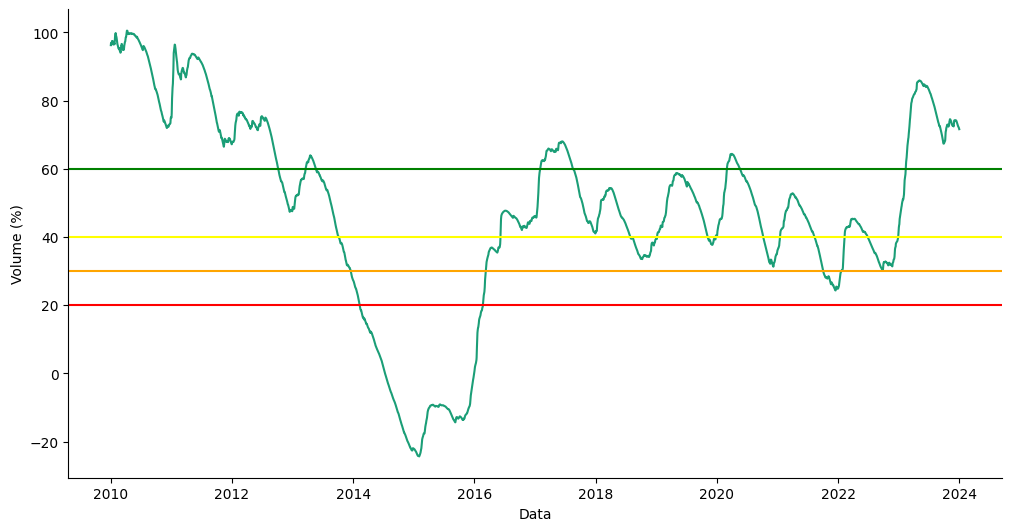

In [35]:
# @title Data vs Volume (%)

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Data']
  ys = series['Volume (%)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dfCantareira.sort_values('Data', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Data')
_ = plt.ylabel('Volume (%)')
ax.axhline(y= 60, ls='-', color='green')
ax.axhline(y= 40, ls='-', color='yellow')
ax.axhline(y= 30, ls='-', color='orange')
ax.axhline(y= 20, ls='-', color='red')


In [36]:
dfTempUmid

,Data,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média,Precipitação (mm)
0,2014-01-01,19.13,32.56,34.12,92.47,96.78
1,2014-02-01,19.64,33.19,30.71,87.19,50.54
2,2014-03-01,18.50,30.04,44.31,93.87,126.59
3,2014-04-01,16.07,27.98,46.72,94.74,78.29
4,2014-05-01,12.76,25.80,43.61,93.62,28.34
...,...,...,...,...,...,...
116,2023-09-01,16.54,31.94,38.44,94.00,74.46
117,2023-10-01,18.44,30.44,55.63,97.17,256.25
118,2023-11-01,18.93,32.24,44.98,95.14,197.55
119,2023-12-01,19.33,33.19,42.62,95.13,86.69


In [37]:
dfCantareira

,Data,Volume (hm³),Volume (%),Chuva (mm),Vazão natural (m³/s),Vazão a jusante (m³/s),Vazão retirada (m³/s)<br/>ETA Guaraú
0,2010-01-01,947.35506,96.24944,0.650,85.995,84.15,NaN
1,2010-01-02,952.34991,96.75691,54.850,164.671,84.14,NaN
2,2010-01-03,953.58761,96.88266,3.875,128.161,87.14,NaN
3,2010-01-04,951.64795,96.68559,0.000,93.507,88.10,NaN
4,2010-01-05,949.31996,96.44907,6.150,90.460,85.97,NaN
...,...,...,...,...,...,...,...
5108,2023-12-27,708.90399,72.18452,6.400,24.091,6.85,28.24206
5109,2023-12-28,707.77838,72.06991,0.000,20.914,6.85,28.56808
5110,2023-12-29,706.88515,71.97895,0.000,25.675,8.02,28.55915
5111,2023-12-30,704.94710,71.78161,0.000,13.881,8.85,25.65419


In [38]:
dfFinal = pd.DataFrame()
dfFinal['Diferença Volume (hm³)'] = dfCantareira['Volume (hm³)'].diff()
dfFinal['Chuva'] = dfCantareira['Chuva (mm)']
dfFinal['Data'] = dfCantareira['Data']
dfFinal

,Diferença Volume (hm³),Chuva,Data
0,NaN,0.650,2010-01-01
1,4.99485,54.850,2010-01-02
2,1.23770,3.875,2010-01-03
3,-1.93966,0.000,2010-01-04
4,-2.32799,6.150,2010-01-05
...,...,...,...
5108,-0.91179,6.400,2023-12-27
5109,-1.12561,0.000,2023-12-28
5110,-0.89323,0.000,2023-12-29
5111,-1.93805,0.000,2023-12-30


In [39]:
dfFinal['Média Móvel Diferença Percentual Volume'] = dfFinal['Diferença Volume (hm³)'].rolling(window=30).sum()
dfFinal['Média Móvel Chuva (mm)'] = dfFinal['Chuva'].rolling(window=30).sum()

In [40]:
dfFinal['Data'] = pd.to_datetime(dfFinal['Data'])

# Criar uma coluna para o ano e mês
dfFinal['AnoMes'] = dfFinal['Data'].dt.to_period('M')

# Agrupar por AnoMes e somar as colunas 'Diferença Volume (hm³)' e 'Chuva (mm)'
df_agrupado = dfFinal.groupby('AnoMes').agg({
    'Média Móvel Diferença Percentual Volume': 'sum',
    'Média Móvel Chuva (mm)': 'sum'
}).reset_index()

# Converter a coluna 'AnoMes' de volta para o formato datetime, usando o primeiro dia do mês
df_agrupado['Data'] = df_agrupado['AnoMes'].dt.to_timestamp()
df_agrupado.columns = ['AnoMes', 'Diferença Volume (hm³)', 'Chuva', 'Data']

# Selecionar e reordenar as colunas conforme necessário
df_resultado = df_agrupado[['Data', 'Diferença Volume (hm³)', 'Chuva']]

# Exibir o DataFrame resultante
print(df_resultado)

          Data  Diferença Volume (hm³)     Chuva
0   2010-01-01                31.53251   970.030
1   2010-02-01              -304.78689  9947.605
2   2010-03-01              -120.46802  5462.745
3   2010-04-01              1023.00628  3825.977
4   2010-05-01               -77.27667   998.393
..         ...                     ...       ...
163 2023-08-01             -1595.28191   224.050
164 2023-09-01             -1616.64078  1790.250
165 2023-10-01               327.70919  7206.720
166 2023-11-01               640.10626  5054.730
167 2023-12-01               -37.15758  4298.450

[168 rows x 3 columns]


In [41]:
df_resultado = df_resultado.query('Data >= datetime.date(2014,1,1) and Data < datetime.date(2024,1,1)')
dfTempUmid = dfTempUmid.query('Data >= datetime.date(2014,1,1) and Data < datetime.date(2024,1,1)')
len(df_resultado) == len(dfTempUmid)

True

In [42]:
df_final = pd.merge(df_resultado, dfTempUmid, on='Data')
df_final = df_final.drop(columns=['Precipitação (mm)'])

In [43]:
df_final

,Data,Diferença Volume (hm³),Chuva,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média
0,2014-01-01,-1442.99273,2412.10,19.13,32.56,34.12,92.47
1,2014-02-01,-1663.97247,1684.05,19.64,33.19,30.71,87.19
2,2014-03-01,-1204.01925,5214.15,18.50,30.04,44.31,93.87
3,2014-04-01,-859.53821,3699.90,16.07,27.98,46.72,94.74
4,2014-05-01,-1169.22647,1253.85,12.76,25.80,43.61,93.62
...,...,...,...,...,...,...,...
115,2023-08-01,-1595.28191,224.05,13.45,28.56,40.21,95.11
116,2023-09-01,-1616.64078,1790.25,16.54,31.94,38.44,94.00
117,2023-10-01,327.70919,7206.72,18.44,30.44,55.63,97.17
118,2023-11-01,640.10626,5054.73,18.93,32.24,44.98,95.14


Remover outliers

In [44]:
def identificar_outliers_iqr(df, coluna):
    # Calcular Q1 (25º percentil) e Q3 (75º percentil)
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)

    # Calcular IQR
    IQR = Q3 - Q1

    # Definir limites inferior e superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar outliers
    print(df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)])

In [45]:
identificar_outliers_iqr(df_final, 'Umidade Máxima Média')
identificar_outliers_iqr(df_final, 'Temp. Máxima Média')

         Data  Diferença Volume (hm³)     Chuva  Temp. Mínima Média  \
9  2014-10-01             -1423.99459  1333.675               16.07   
48 2018-01-01               889.02256  6341.700               11.08   
49 2018-02-01              1721.47038  5056.100               10.53   
50 2018-03-01               771.98507  5269.950               11.42   
51 2018-04-01              -188.31514  2362.250                8.13   
52 2018-05-01             -1371.76291   209.450                5.08   
53 2018-06-01              -981.37585   649.150                5.59   
54 2018-07-01             -1033.92648   209.350                5.94   
55 2018-08-01              -821.98805  2138.050               11.70   

    Temp. Máxima Média  Umidade Mínima Média  Umidade Máxima Média  
9                31.19                 27.00                 84.86  
48               21.33                 42.46                 82.88  
49               21.33                 39.72                 81.67  
50           

In [46]:
df_final.iloc[[52,55,79]]

,Data,Diferença Volume (hm³),Chuva,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média
52,2018-05-01,-1371.76291,209.45,5.08,18.93,30.14,188.88
55,2018-08-01,-821.98805,2138.05,11.70,24.88,47.15,223.23
79,2020-08-01,-1337.90678,646.65,11.30,94.84,37.66,91.88


In [47]:
df_final.loc[52, 'Umidade Máxima Média'] = 100
df_final.loc[55, 'Umidade Máxima Média'] = 100

In [48]:
df_final.iloc[[78,79,80]]

,Data,Diferença Volume (hm³),Chuva,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média
78,2020-07-01,-892.86482,1300.25,11.29,26.90,38.63,94.93
79,2020-08-01,-1337.90678,646.65,11.30,94.84,37.66,91.88
80,2020-09-01,-1549.60367,962.35,15.68,64.73,29.20,90.69


In [49]:
df_final.loc[79, 'Temp. Máxima Média'] = 45.81 #média

In [73]:
df_final.iloc[:,1:]

,Diferença Volume (hm³),Chuva,Temp. Mínima Média,Temp. Máxima Média,Umidade Mínima Média,Umidade Máxima Média
0,-1442.99273,2412.10,19.13,32.56,34.12,92.47
1,-1663.97247,1684.05,19.64,33.19,30.71,87.19
2,-1204.01925,5214.15,18.50,30.04,44.31,93.87
3,-859.53821,3699.90,16.07,27.98,46.72,94.74
4,-1169.22647,1253.85,12.76,25.80,43.61,93.62
...,...,...,...,...,...,...
115,-1595.28191,224.05,13.45,28.56,40.21,95.11
116,-1616.64078,1790.25,16.54,31.94,38.44,94.00
117,327.70919,7206.72,18.44,30.44,55.63,97.17
118,640.10626,5054.73,18.93,32.24,44.98,95.14


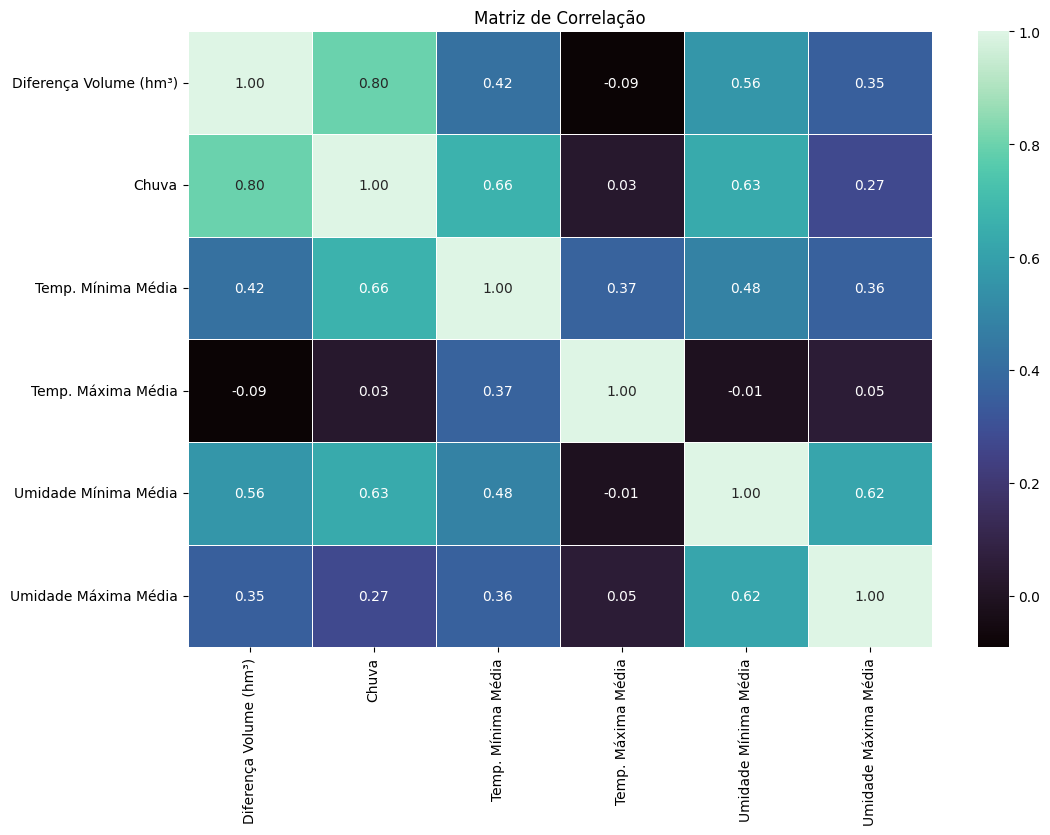

In [75]:
correlation_matrix = df_final.iloc[:,1:].corr()

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 8))

# Criar o heatmap usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f', linewidths=0.5)

# Adicionar título ao heatmap
plt.title('Matriz de Correlação')

# Exibir o gráfico
plt.show()

<Figure size 1200x800 with 0 Axes>

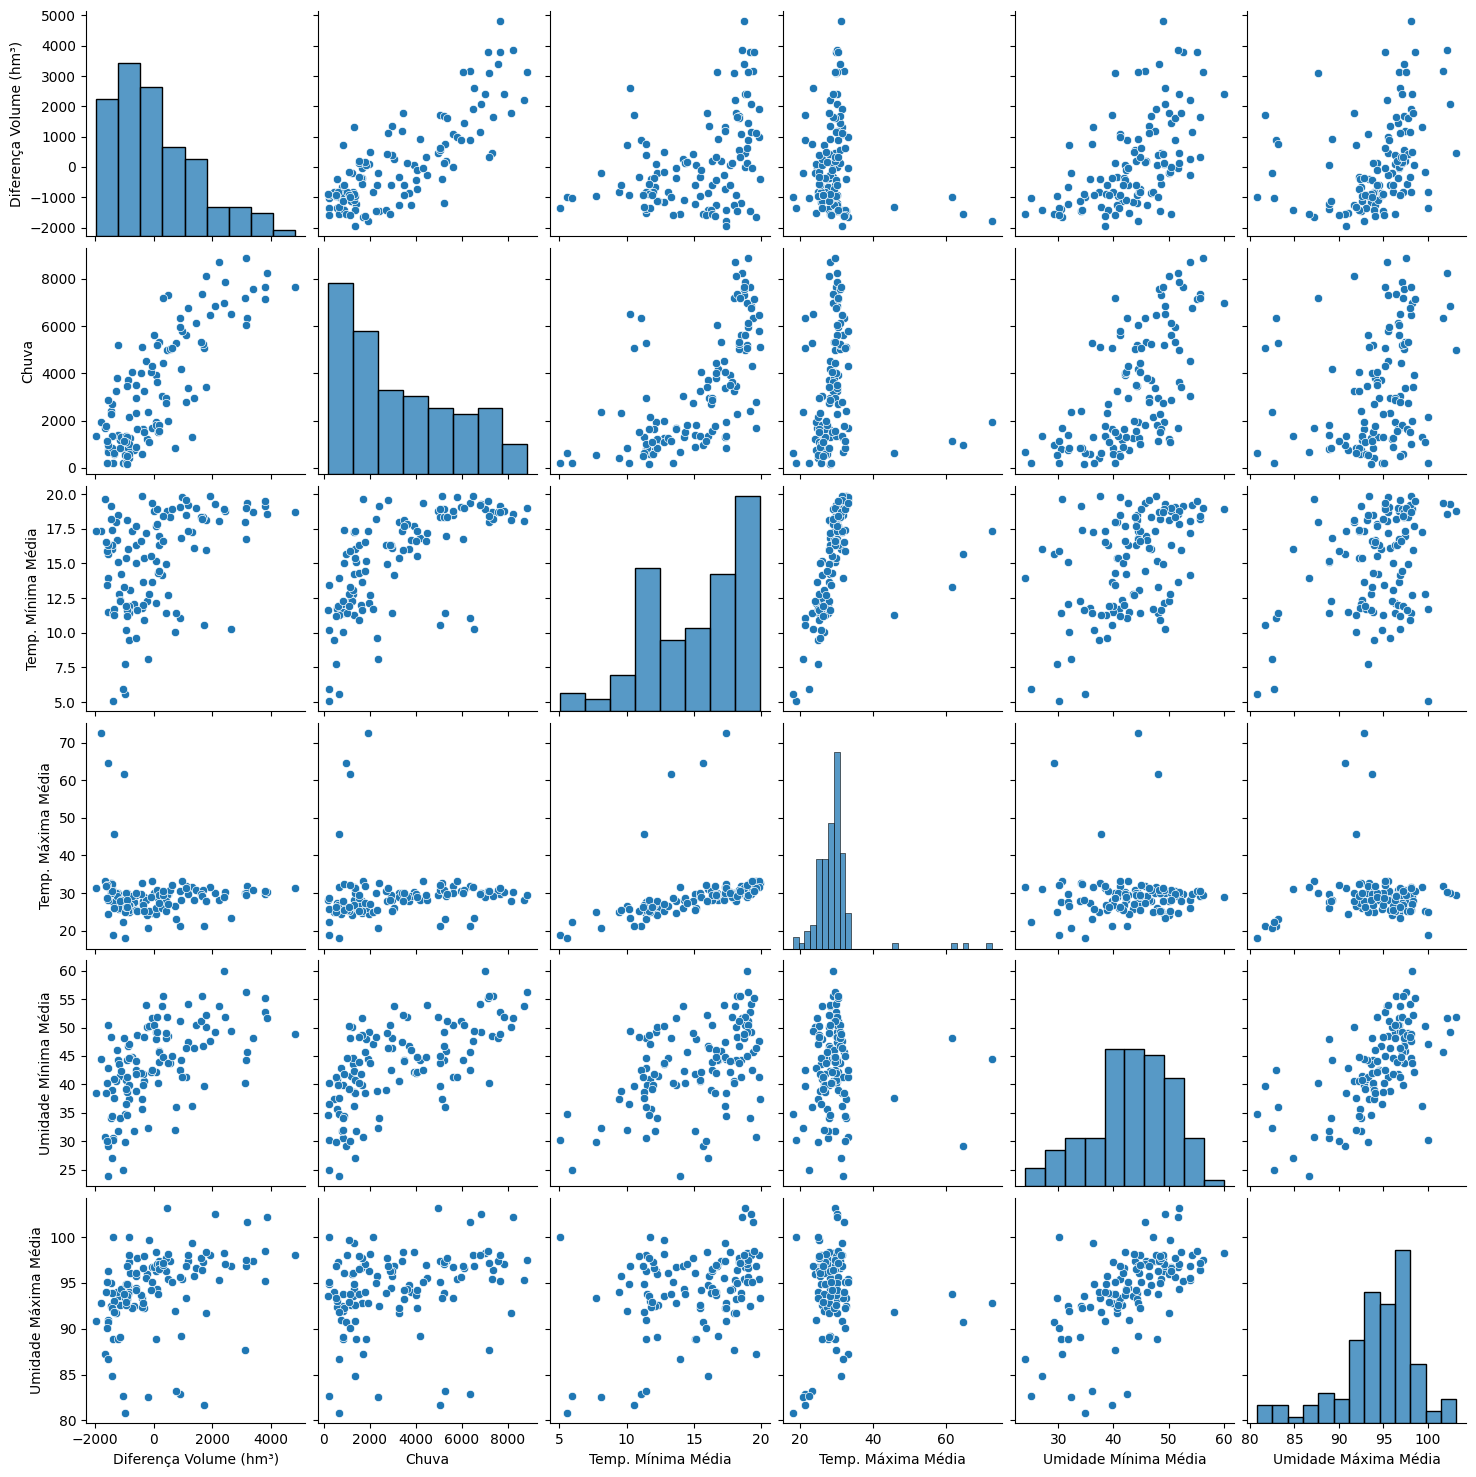

In [50]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_final);

In [51]:
X = df_final[['Chuva', 'Temp. Mínima Média', 'Temp. Máxima Média', 'Umidade Mínima Média', 'Umidade Máxima Média']]

In [52]:
y = df_final[['Diferença Volume (hm³)']]

In [53]:
y.describe()

,Diferença Volume (hm³)
count,120.000000
mean,107.099130
std,1469.543804
min,-1955.682370
25%,-966.468093
50%,-239.668770
75%,908.297015
max,4812.998840


In [54]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


# Regressão Linear Múltipla

In [55]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 668.2696657973393
MAE: 524.473482672304
R²: 0.836263402286597


In [58]:
coeficientes = model.coef_
coeficientes

array([[ 4634.19829957, -1209.03355932,  -510.27665869,  -317.77571935,
         1430.43462613]])

In [59]:
intercepto = model.intercept_
intercepto

array([-1303.76217183])

# Árvore de Regressão

In [60]:
model = DecisionTreeRegressor()
param_grid = {
    #'criterion': ['mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'random'}

In [61]:
model = DecisionTreeRegressor(max_features='auto', min_samples_leaf = 2, min_samples_split = 10)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular RMSE, MAE e R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Exibir os resultados
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 803.3546155036839
MAE: 633.9116568055555
R²: 0.7633770566357334


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [62]:
model.feature_importances_

array([0.87916814, 0.00260444, 0.00452485, 0.00841473, 0.10528784])

# Ramdom Florest Regression

In [63]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': range(50,251,50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)
grid_search.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [64]:
model = RandomForestRegressor(n_estimators=100, min_samples_split = 2, min_samples_leaf=4,max_features='auto', random_state=42)
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Calcular RMSE, MAE e R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Exibir os resultados
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

<ipython-input-64-680697b1f30c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RMSE: 648.8885573156506
MAE: 524.9180591850451
R²: 0.8456230354142069


In [65]:
model.feature_importances_

array([0.79485983, 0.022636  , 0.04578355, 0.0352679 , 0.10145272])

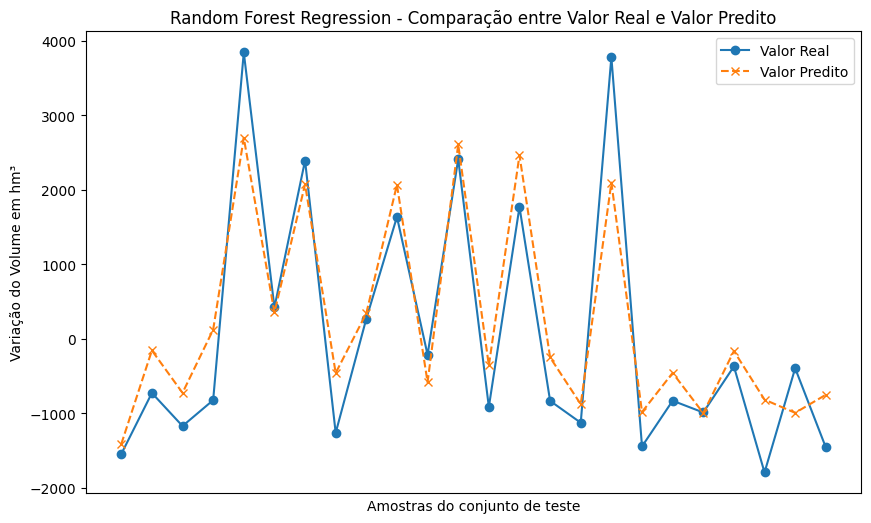

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Valor Real', linestyle='-', marker='o')
plt.plot(range(len(y_pred)), y_pred, label='Valor Predito', linestyle='--', marker='x')

# Adicione título e rótulos aos eixos
plt.title('Random Forest Regression - Comparação entre Valor Real e Valor Predito')
plt.xlabel('Amostras do conjunto de teste')
plt.ylabel('Variação do Volume em hm³')
plt.xticks([])

# Adicione a legenda
plt.legend()

# Exiba o gráfico
plt.show()

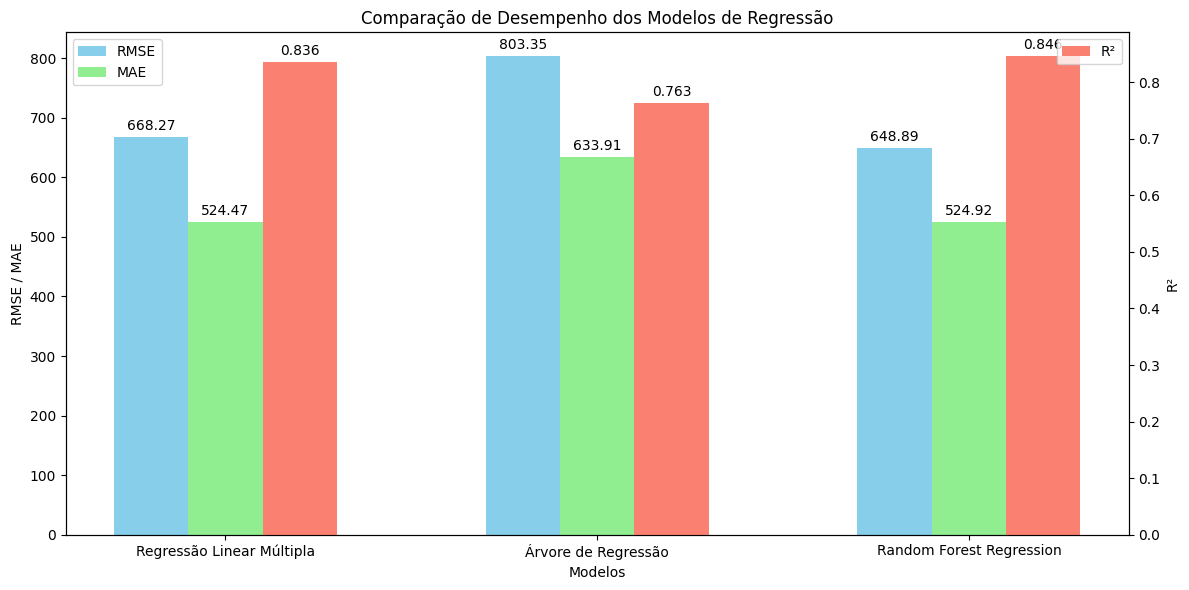

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Dados dos modelos
models = ['Regressão Linear Múltipla', 'Árvore de Regressão', 'Random Forest Regression']
rmse = [668.27, 803.35, 648.89]
mae = [524.47, 633.91, 524.92]
r2 = [0.836, 0.763, 0.846]

# Configurações do gráfico
x = np.arange(len(models))  # a localização dos modelos
width = 0.2  # a largura das barras

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar RMSE
bars1 = ax1.bar(x - width, rmse, width, label='RMSE', color='skyblue')

# Plotar MAE
bars2 = ax1.bar(x, mae, width, label='MAE', color='lightgreen')

# Criar um segundo eixo y para o R²
ax2 = ax1.twinx()
bars3 = ax2.bar(x + width, r2, width, label='R²', color='salmon')

# Adicionar títulos e rótulos
ax1.set_xlabel('Modelos')
ax1.set_ylabel('RMSE / MAE')
ax2.set_ylabel('R²')
ax1.set_title('Comparação de Desempenho dos Modelos de Regressão')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Adicionar legendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adicionar os valores no topo das barras
def add_labels(bars, ax, value_format="{}"):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{value_format.format(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1, ax1, "{:.2f}")
add_labels(bars2, ax1, "{:.2f}")
add_labels(bars3, ax2, "{:.3f}")

fig.tight_layout()  # para ajustar o layout e evitar sobreposição

plt.show()
